# Implementing Soft-Actor-Critic from original paper (2018)  
(https://arxiv.org/pdf/1801.01290.pdf)
### References: 
OpenAI Gym <br/>
https://github.com/vaishak2future/sac/blob/master/sac.ipynb <br/>
https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665

In [3]:
import agents.py
import custom_envs
import reward 
import utils
import sys
import random
import pandas as pd
import importlib
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import torch.distributions as tdist

ModuleNotFoundError: No module named 'agents'

## Using Vaishak Kumar's implementation of version 1

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
class Space():
    def __init__(self, low, high, length, dtype):
        self.shape = (length)
        self.dtype = np.dtype(dtype)
        self.low = low
        self.high = high

class ActionSpace(Space):
    def __init__(self, low = 0, high = 10, length=24, dtype= np.float32):
        super().__init__(low, high, length, dtype)
    
    def sample(self):
        return np.random.uniform(self.low,self.high,self.shape)

class StateSpace(Space):
    def __init__(self, low = 0, high = 100, length=24, dtype= np.float32):
        super().__init__(low, high, length, dtype)

In [ ]:
class NormalizedActions(ActionSpace):
    def __init__(self):
        self.action_space = ActionSpace()
        self.state_space = StateSpace()
        
    def _action(self, action):
        """
        Input: Action- a np_array of length= self.length (self refers to NormalizedActions)
        Returns: "normalized action"
        """
        low  = np.ones(self.length) * self.low
        high = np.ones(self.length) * self.high
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.low
        high = self.high
        action_prime = []
        for x in np.nditer(action):
            x_prime = 2*(x-low) / (high-low) - 1
            action_prime.append(x_prime)
        action_prime = np.array(action_prime)
        action_prime = np.clip(action_prime, low, high)
        
        return action_prime
    
    def step(self, office, price, controllers_points):
        end = False
        energy_dict = {}
        rewards_dict = {}
        # DO per person reward!!
        # Add per person to parameter ^^^^
        # Add i to the state 
        # or add map i: kwh_i, or reference yesterday player energy
        count = 0
        energy = None
        for player_name in office.players_dict:
            if(count < 10000000):
                player = office.players_dict.get(player_name)
                player_energy = player.sin_response(controllers_points)
                energy = player_energy
                last_player_energy = player_energy
                energy_dict[player_name] = player_energy

                player_min_demand = player.get_min_demand()
                player_max_demand = player.get_max_demand()
                player_reward = simulation.Reward(player_energy, price[0:24], player_min_demand, player_max_demand)
                player_ideal_demands = player_reward.ideal_use_calculation()
                last_player_ideal = player_ideal_demands
                reward = player_reward.scaled_cost_distance_neg(player_ideal_demands)
                rewards_dict[player_name] = reward
                count += 1
        
        total_reward = sum(rewards_dict.values())
        office._timestep = office._timestep + office._time_interval
        
        if office._timestep>office._end_timestamp:
            office._timestep = office._start_timestamp

        #Traininng on one day!
        diff = (office.get_timestep()-office._start_timestamp)
        next_price = price #office.price_signal(diff.days + 1)
        next_state = next_price #np.concatenate([next_price, energy])
        return next_state, total_reward, end

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
#         print(state.shape)
#         print(action.shape)
        x = torch.cat([state, action],1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z = normal.sample() #.to(device)
        action = torch.sigmoid(mean+ std*z)
        #action = action.to(dtype = torch.int32)
#       log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = Normal(mean, std).log_prob(mean+ std*z) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_points(self, state):
        state = torch.FloatTensor(state).unsqueeze(0) #.to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z = normal.sample() #.to(device)
        action = torch.sigmoid(mean+ std*z)
        #action = action.to(dtype = torch.int32)
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

In [6]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state) #.to(device)
    next_state = torch.FloatTensor(next_state) #.to(device)
    action     = torch.FloatTensor(action) #.to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1) #.to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1) #.to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [7]:
env = NormalizedActions()

action_dim = env.action_space.shape
state_dim  = env.state_space.shape
hidden_dim = 32

value_net        = ValueNetwork(state_dim, hidden_dim) #.to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim) #.to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim) #.to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim) #.to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim) #.to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 10000


## Hyperparam

In [8]:
max_steps = 2000
batch_size = 25
value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

creating agents
creating controller
0 / 2000
1 / 2000
2 / 2000
3 / 2000
4 / 2000
5 / 2000
6 / 2000
7 / 2000
8 / 2000
9 / 2000
10 / 2000
11 / 2000
12 / 2000
13 / 2000
14 / 2000
15 / 2000
16 / 2000
17 / 2000
18 / 2000
19 / 2000
20 / 2000
21 / 2000
22 / 2000
23 / 2000
24 / 2000
25 / 2000


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([25, 24])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


26 / 2000
27 / 2000
28 / 2000
29 / 2000
30 / 2000
31 / 2000
32 / 2000
33 / 2000
34 / 2000
35 / 2000
36 / 2000
37 / 2000
38 / 2000
39 / 2000
40 / 2000
41 / 2000
42 / 2000
43 / 2000
44 / 2000
45 / 2000
46 / 2000
47 / 2000
48 / 2000
49 / 2000
50 / 2000
51 / 2000
52 / 2000
53 / 2000
54 / 2000
55 / 2000
56 / 2000
57 / 2000
58 / 2000
59 / 2000
60 / 2000
61 / 2000
62 / 2000
63 / 2000
64 / 2000
65 / 2000
66 / 2000
67 / 2000
68 / 2000
69 / 2000
70 / 2000
71 / 2000
72 / 2000
73 / 2000
74 / 2000
75 / 2000
76 / 2000
77 / 2000
78 / 2000
79 / 2000
80 / 2000
81 / 2000
82 / 2000
83 / 2000
84 / 2000
85 / 2000
86 / 2000
87 / 2000
88 / 2000
89 / 2000
90 / 2000
91 / 2000
92 / 2000
93 / 2000
94 / 2000
95 / 2000
96 / 2000
97 / 2000
98 / 2000
99 / 2000
100 / 2000
101 / 2000
102 / 2000
103 / 2000
104 / 2000
105 / 2000
106 / 2000
107 / 2000
108 / 2000
109 / 2000
110 / 2000
111 / 2000
112 / 2000
113 / 2000
114 / 2000
115 / 2000
116 / 2000
117 / 2000
118 / 2000
119 / 2000
120 / 2000
121 / 2000
122 / 2000
123 / 2

778 / 2000
779 / 2000
780 / 2000
781 / 2000
782 / 2000
783 / 2000
784 / 2000
785 / 2000
786 / 2000
787 / 2000
788 / 2000
789 / 2000
790 / 2000
791 / 2000
792 / 2000
793 / 2000
794 / 2000
795 / 2000
796 / 2000
797 / 2000
798 / 2000
799 / 2000
800 / 2000
801 / 2000
802 / 2000
803 / 2000
804 / 2000
805 / 2000
806 / 2000
807 / 2000
808 / 2000
809 / 2000
810 / 2000
811 / 2000
812 / 2000
813 / 2000
814 / 2000
815 / 2000
816 / 2000
817 / 2000
818 / 2000
819 / 2000
820 / 2000
821 / 2000
822 / 2000
823 / 2000
824 / 2000
825 / 2000
826 / 2000
827 / 2000
828 / 2000
829 / 2000
830 / 2000
831 / 2000
832 / 2000
833 / 2000
834 / 2000
835 / 2000
836 / 2000
837 / 2000
838 / 2000
839 / 2000
840 / 2000
841 / 2000
842 / 2000
843 / 2000
844 / 2000
845 / 2000
846 / 2000
847 / 2000
848 / 2000
849 / 2000
850 / 2000
851 / 2000
852 / 2000
853 / 2000
854 / 2000
855 / 2000
856 / 2000
857 / 2000
858 / 2000
859 / 2000
860 / 2000
861 / 2000
862 / 2000
863 / 2000
864 / 2000
865 / 2000
866 / 2000
867 / 2000
868 / 2000

1480 / 2000
1481 / 2000
1482 / 2000
1483 / 2000
1484 / 2000
1485 / 2000
1486 / 2000
1487 / 2000
1488 / 2000
1489 / 2000
1490 / 2000
1491 / 2000
1492 / 2000
1493 / 2000
1494 / 2000
1495 / 2000
1496 / 2000
1497 / 2000
1498 / 2000
1499 / 2000
1500 / 2000
1501 / 2000
1502 / 2000
1503 / 2000
1504 / 2000
1505 / 2000
1506 / 2000
1507 / 2000
1508 / 2000
1509 / 2000
1510 / 2000
1511 / 2000
1512 / 2000
1513 / 2000
1514 / 2000
1515 / 2000
1516 / 2000
1517 / 2000
1518 / 2000
1519 / 2000
1520 / 2000
1521 / 2000
1522 / 2000
1523 / 2000
1524 / 2000
1525 / 2000
1526 / 2000
1527 / 2000
1528 / 2000
1529 / 2000
1530 / 2000
1531 / 2000
1532 / 2000
1533 / 2000
1534 / 2000
1535 / 2000
1536 / 2000
1537 / 2000
1538 / 2000
1539 / 2000
1540 / 2000
1541 / 2000
1542 / 2000
1543 / 2000
1544 / 2000
1545 / 2000
1546 / 2000
1547 / 2000
1548 / 2000
1549 / 2000
1550 / 2000
1551 / 2000
1552 / 2000
1553 / 2000
1554 / 2000
1555 / 2000
1556 / 2000
1557 / 2000
1558 / 2000
1559 / 2000
1560 / 2000
1561 / 2000
1562 / 2000
1563

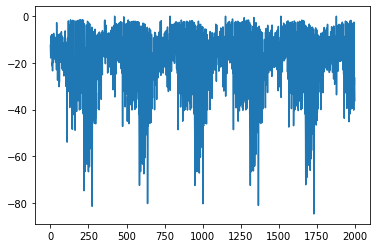

In [9]:
replay_buffer = ReplayBuffer(replay_buffer_size)
office = simulation.Office()
diff = (office.get_timestep()-office._start_timestamp)
state = office.price_signal(diff.days + 50) #np.concatenate([office.price_signal(diff.days + 50), np.zeros(24)])
rewards = []
action_star = None
for step in range(max_steps):
    print((str(step) + " / " + str(max_steps)))
    if step >110:
        action = policy_net.get_points(state).detach()
        next_state, reward, done = env.step(office, state, action.numpy())
    else:
        action = env.action_space.sample()
        next_state, reward, done = env.step(office, state, action) 
        #office.step -> returns reward, action, kwh, end
            # State = price for today and energy used yesterday(?)
            # need to add price to state
        
    action_star = action
    replay_buffer.push(state, action, reward, next_state, done)
        
    state = next_state
        
    if len(replay_buffer) > batch_size:
            update(batch_size)
        
    if done:
        break
        
    rewards.append(reward)

rewards = [r[0] if r is np.ndarray else r for r in rewards]
plt.plot(np.array(range(max_steps)),rewards)



tensor([2.2696e-13, 2.2431e-09, 7.4564e-12, 9.8500e-01, 1.9718e-11, 9.4249e-01,
        9.8661e-01, 1.0000e+00, 5.8004e-11, 1.8312e-09, 1.2977e-10, 5.4365e-16,
        1.0000e+00, 1.7499e-12, 9.9480e-01, 1.7416e-11, 1.0000e+00, 9.9997e-01,
        4.6634e-11, 5.4439e-04, 1.0000e+00, 5.6090e-11, 8.8656e-06, 2.7853e-15])
----
tensor([5.8004e-11, 1.8312e-09, 1.2977e-10, 5.4365e-16, 1.0000e+00, 1.7499e-12,
        9.9480e-01, 1.7416e-11, 1.0000e+00])


Text(0.5, 1.0, 'Price of Energy Today (SAC V1)')

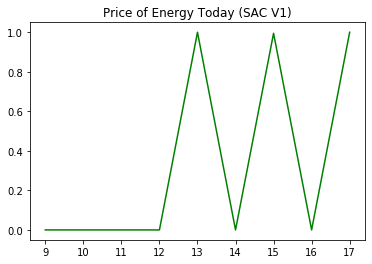

In [10]:
action_prime = action_star[8:17]
print(action_star)
print("----")
print(action_prime)
plt.plot(np.array([i for i in range(9,18)]),np.array(action_prime), color = 'green')
plt.title("Price of Energy Today (SAC V1)")

Text(0.5, 1.0, 'Rewards (SAC V1)')

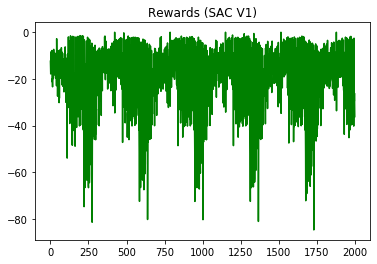

In [11]:
plt.plot(np.array(range(max_steps)),rewards, color='green')
plt.title("Rewards (SAC V1)")